In [1]:
from fastai.vision.all import *
import fastai
import timm
import torch
import albumentations as A
transform = A.load("/media/newhd/OPTRetina/DMAE/autoalbument-amd/outputs/2021-11-24/10-32-22/policy/latest.json")

class AlbumentationsTransform(Transform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [2]:
torch.cuda.set_device(0)

In [3]:
df = pd.read_csv('../trainValid.csv')

In [4]:
df

,Unnamed: 0,nombre_foto,grado de DMAE,binary,set
0,61504,anonymized_231059.jpg,normal,0,training
1,176989,anonymized_442122.jpg,normal,0,training
2,133399,anonymized_363034.jpg,normal,0,training
3,220150,anonymized_519072.jpg,normal,0,training
4,155853,anonymized_403989.jpg,normal,0,training
...,...,...,...,...,...
7797,224854,anonymized_528388.jpg,tardia,1,validation
7798,225492,anonymized_529721.jpg,intermedia,1,validation
7799,226322,anonymized_531350.jpg,precoz,1,validation
7800,227489,anonymized_533460.jpg,tardia,1,validation


In [5]:
def is_valid(path):
    name = path[1]
    return (df[df['nombre_foto']==name])['set'].values[0]=='validation'

# 224

In [6]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='efficientnet_b3_244_b',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [7]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384),AlbumentationsTransform(transform[0])], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [8]:
dls = db.dataloaders(df.values,bs=32,num_workers=0)

In [9]:
learn = Learner(dls,timm.create_model('efficientnet_b3',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.871521,0.777049,0.796154,0.888889,0.676923,0.768559,0.900733,02:08


Better model found at epoch 0 with f1_score value: 0.7685589519650655.


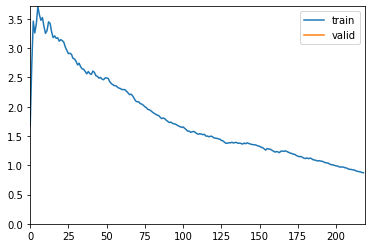

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.227228,0.106423,0.844872,0.849351,0.838462,0.843871,0.927482,02:09
1,0.164843,0.105312,0.861538,0.820455,0.925641,0.869880,0.937676,02:10
2,0.160573,0.091026,0.852564,0.810384,0.920513,0.861945,0.939024,02:08
3,0.113267,0.080467,0.864103,0.925150,0.792308,0.853591,0.952255,02:09
4,0.122865,0.094831,0.826923,0.918033,0.717949,0.805755,0.947337,02:09
5,0.109487,0.145291,0.821795,0.966543,0.666667,0.789074,0.948366,02:09
6,0.098840,0.085908,0.843590,0.782700,0.951282,0.858796,0.948468,02:09
7,0.093088,0.084934,0.860256,0.817156,0.928205,0.869148,0.951578,02:08
8,0.085477,0.123830,0.830769,0.759036,0.969231,0.851351,0.954132,02:09


Better model found at epoch 0 with f1_score value: 0.8438709677419356.


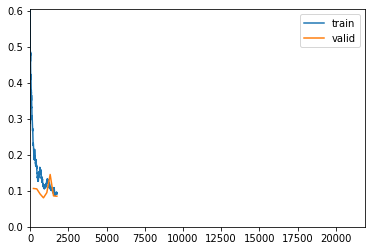

Better model found at epoch 1 with f1_score value: 0.8698795180722891.
No improvement since epoch 3: early stopping


In [10]:
learn.fine_tune(100,base_lr=3e-3)

In [11]:
dfTest = pd.read_csv('../testSample.csv')

In [12]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [13]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [14]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=64,num_workers=0)

In [15]:
learn.dls = dlsTest

In [16]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.958843392504931.


(#6) [0.11005640774965286,0.8871794939041138,0.8485687903970452,0.9425641025641026,0.8931000971817298,0.958843392504931]

# 384

In [17]:
import torch
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='efficientnet_b3_384_b',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [18]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512),AlbumentationsTransform(transform[0])], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [19]:
dls = db.dataloaders(df.values,bs=32,num_workers=0)

In [20]:
learn = Learner(dls,timm.create_model('efficientnet_b3',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

In [21]:
learn.load('efficientnet_b3_244_b')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


SuggestedLRs(valley=9.120108734350652e-05)

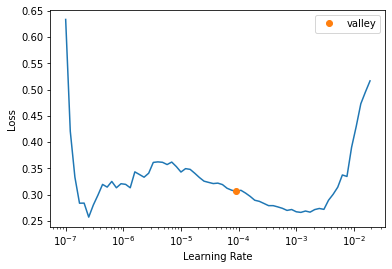

In [22]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.204680,0.127449,0.797436,0.851515,0.720513,0.780556,0.890973,02:31


Better model found at epoch 0 with f1_score value: 0.7805555555555554.


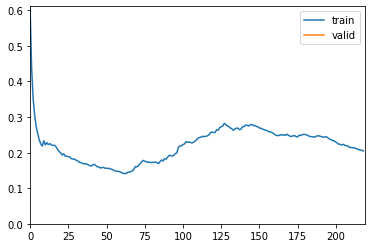

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.098810,0.091249,0.835897,0.870056,0.789744,0.827957,0.934763,02:30
1,0.091430,0.093504,0.858974,0.926829,0.779487,0.846797,0.944112,02:30
2,0.090574,0.069008,0.874359,0.892473,0.851282,0.871391,0.957584,02:30
3,0.085642,0.076057,0.861538,0.887363,0.828205,0.856764,0.948439,02:30
4,0.082743,0.076638,0.864103,0.903409,0.815385,0.857143,0.948889,02:30
5,0.081975,0.081229,0.871795,0.831050,0.933333,0.879227,0.953452,02:30
6,0.080696,0.083899,0.858974,0.897727,0.810256,0.851752,0.939688,02:30
7,0.074319,0.086589,0.858974,0.828638,0.905128,0.865196,0.945746,02:29


Better model found at epoch 0 with f1_score value: 0.8279569892473116.


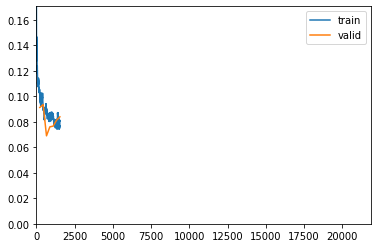

Better model found at epoch 1 with f1_score value: 0.8467966573816156.
Better model found at epoch 2 with f1_score value: 0.8713910761154856.
Better model found at epoch 5 with f1_score value: 0.8792270531400966.
No improvement since epoch 2: early stopping


In [23]:
learn.fine_tune(100,base_lr=3e-3)

In [24]:
dfTest = pd.read_csv('../testSample.csv')

In [25]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [26]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [27]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=64,num_workers=0)

In [28]:
learn.dls = dlsTest

In [29]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9656631163708086.


(#6) [0.07407740503549576,0.8943589925765991,0.8623939679547596,0.9384615384615385,0.8988212180746562,0.9656631163708086]

# 512

In [30]:
import torch
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='efficientnet_b3_512_b',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [31]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(640),AlbumentationsTransform(transform[0])], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=512, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [32]:
dls = db.dataloaders(df.values,bs=8,num_workers=0)

In [33]:
learn = Learner(dls,timm.create_model('efficientnet_b3',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

In [34]:
learn.load('efficientnet_b3_384_b')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


SuggestedLRs(valley=2.75422871709452e-06)

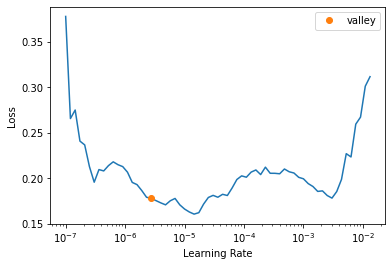

In [35]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.176856,0.150444,0.682051,0.973333,0.374359,0.540741,0.864556,04:49


Better model found at epoch 0 with f1_score value: 0.5407407407407407.


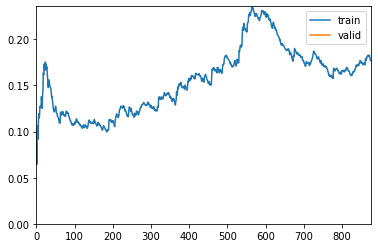

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.107721,0.087597,0.847436,0.826506,0.879487,0.852174,0.931660,04:40
1,0.105120,0.098809,0.821795,0.963100,0.669231,0.789713,0.939320,04:40
2,0.100530,0.093627,0.835897,0.786026,0.923077,0.849057,0.937945,04:38
3,0.094511,0.084709,0.855128,0.931464,0.766667,0.841069,0.947604,04:38
4,0.093181,0.079952,0.866667,0.897222,0.828205,0.861333,0.944862,04:38
5,0.091943,0.084571,0.841026,0.784188,0.941026,0.855478,0.951183,04:37
6,0.091451,0.086442,0.851282,0.872283,0.823077,0.846966,0.940089,04:38
7,0.088158,0.113454,0.803846,0.961089,0.633333,0.763524,0.935950,04:38
8,0.086061,0.078276,0.871795,0.916667,0.817949,0.864499,0.947738,04:38
9,0.085681,0.088057,0.851282,0.941935,0.748718,0.834286,0.946358,04:38


Better model found at epoch 0 with f1_score value: 0.8521739130434782.


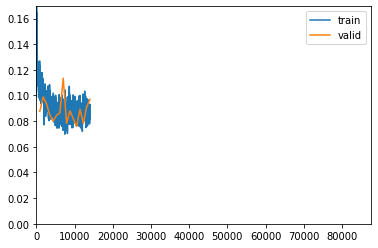

Better model found at epoch 4 with f1_score value: 0.8613333333333333.
Better model found at epoch 8 with f1_score value: 0.8644986449864498.
Better model found at epoch 11 with f1_score value: 0.8666666666666667.
Better model found at epoch 13 with f1_score value: 0.8672798948751643.
Better model found at epoch 14 with f1_score value: 0.8717948717948718.
No improvement since epoch 11: early stopping


In [36]:
learn.fine_tune(100,base_lr=3e-3)

In [37]:
dfTest = pd.read_csv('../testSample.csv')

In [38]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [39]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(640)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=512, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [40]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=8,num_workers=0)

In [41]:
learn.dls = dlsTest

In [42]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9555960552268244.


(#6) [0.07613105326890945,0.8979487419128418,0.901656314699793,0.8933333333333333,0.8974755280783101,0.9555960552268244]